# Dependencies

In [1]:
import time, os, math
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as plt
import seaborn as sns
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import plotly
import plotly.plotly as py
from plotly.graph_objs import Scatter, Layout

import paths
from TRMM import TRMM
from ModelHelpers import ModelHelpers
from ModelTRMMv2 import ModelTRMMv2
from Visualization import Visualization

# force autoreload of external modules on save
%load_ext autoreload
%autoreload 2
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

Using TensorFlow backend.


In [2]:
onset_dates, onset_ts = ModelHelpers.load_onset_dates()

In [35]:
YEARS = range(1998, 2017)
PRE_MONSOON = [3, 4, 5]
PREDICT_ON = '{}-05-11' # year is variable

onset_dates, onset_ts = ModelHelpers.load_onset_dates()
prediction_ts = ModelHelpers.generate_prediction_ts(PREDICT_ON, YEARS)

def filter_fun(df, year):
    return ModelHelpers.filter_until(df, prediction_ts[year])

df = TRMM.load_dataset(YEARS, PRE_MONSOON, filter_fun=filter_fun, aggregation_resolution=2.5, bundled=False)

> Loading from cache...


In [30]:
indexed_coords = df[1998].reset_index()[['latitude', 'longitude']]

In [31]:
df[1998].shape

(169, 92)

In [34]:
df[1998].head(20)

888710400   888796800   888883200   888969600  889056000  \
latitude longitude                                                             
6.375    63.625      0.270000    0.090000    0.000000    0.420000   0.000000   
         66.125      0.030000   10.080000    0.000000    2.430000   0.000000   
         68.625     20.159999    4.560000    0.000000   64.409999   0.000000   
         71.125      4.020000    0.090000    8.430000  109.139997  16.920000   
         73.625      2.160000    0.000000   22.559999   66.629998  70.619998   
         76.125      0.000000    9.060000   72.539997   22.470000  18.510000   
         78.625      0.000000   60.214850   80.435100   64.229998  31.971195   
         81.125     10.935764   67.841266  255.561632   43.655099  39.983594   
         83.625      0.000000  128.789995  132.599995   65.579998  57.839998   
         86.125      0.000000  136.109996  122.429997   70.619998  10.440000   
         88.625      0.000000   80.129998  268.319994  124.139998   0.120000   
         91.125      0.000000   50.550000  136.230000   46.320000   0.840000   
         93.625      0.420000  208.709996   75.569997   43.800000  11.220000   
8.875    63.625      0.000000    0.000000    0.000000    0.030000   0.000000   
         66.125      1.080000    0.030000    0.000000    0.030000   0.000000   
         68.625     17.729999    0.030000    0.000000    1.890000   0.000000   
         71.125     12.840000    0.060000    0.000000   38.880000   0.180000   
         73.625      7.080000    0.090000   12.450000  174.839995   2.190000   
         76.125      0.839232    3.263753    8.118923   23.941233  20.257312   
         78.625      0.000000    0.810000    0.810000   11.715069  12.001294   

                     889142400  889228800   889315200  889401600  889488000  \
latitude longitude                                                            
6.375    63.625      13.020000   0.000000   27.119999   0.120000   0.000000   
         66.125      26.460000   0.030000    3.480000   0.000000   0.030000   
         68.625      13.589999   0.000000    4.110000   0.000000   0.720000   
         71.125     115.829996   0.000000    0.570000   0.000000   0.000000   
         73.625      41.849998   0.000000    0.000000   0.000000   6.990000   
         76.125       1.710000   0.090000    0.000000   0.000000   0.480000   
         78.625      42.385844  72.436202  101.763287   5.238812  74.406729   
         81.125      52.779131   3.450681  178.950657  23.863991   0.161178   
         83.625       8.070000   0.120000    0.030000   2.130000   0.000000   
         86.125       0.060000   0.030000    0.000000   1.020000   0.000000   
         88.625       0.000000   0.000000    2.520000   6.870000   3.960000   
         91.125       2.970000   6.780000    6.960000   3.810000   0.180000   
         93.625       7.920000   4.080000   14.400000  18.749999   6.540000   
8.875    63.625       0.000000   0.000000    7.020000   0.000000   0.000000   
         66.125       0.000000   0.000000    0.180000   0.000000   0.000000   
         68.625       0.000000   0.000000    0.000000   0.000000   0.000000   
         71.125       0.900000   0.000000    0.000000   0.000000   0.000000   
         73.625       0.780000   0.000000    0.000000   0.000000  12.360000   
         76.125      35.912656   0.753470    0.000000   0.000000   5.448712   
         78.625       0.000000   0.000000    0.000000   0.180000   0.000000   

                       ...         895795200    895881600    895968000  \
latitude longitude     ...                                               
6.375    63.625        ...         21.750000   173.309995   133.439995   
         66.125        ...         68.129998   199.679996   426.539986   
         68.625        ...         70.829998    45.269999   610.649990   
         71.125        ...         25.169999    36.629999    68.459999   
         73.625        ...          6.210000     0.780000     9.840000   
  

In [33]:
df[1998].tail()

888710400  888796800   888883200  888969600  889056000  \
latitude longitude                                                           
36.375   83.625      0.000000  15.144474   12.215455   5.830503   0.070860   
         86.125      0.000000   0.000000   32.847053  17.640607   0.978523   
         88.625      0.510000   0.000000   17.672167  39.567700   1.068000   
         91.125      0.790152   0.000000   21.308006  13.305460   2.724581   
         93.625     11.444236   0.060000  110.975858   4.604388   4.086000   

                    889142400  889228800  889315200  889401600  889488000  \
latitude longitude                                                          
36.375   83.625      0.096000   0.282567   0.000000      0.000        0.0   
         86.125      0.390000   0.000000   0.000000      0.000        0.0   
         88.625      6.576000   0.000000   1.464000      0.006        0.0   
         91.125     26.437383   1.919495   1.623547      0.000        0.0   
         93.625     16.782562  27.383104   4.938000      0.000        0.0   

                      ...      895795200  895881600  895968000  896054400  \
latitude longitude    ...                                                   
36.375   83.625       ...        2.27400   1.914000   0.828000   0.102000   
         86.125       ...        0.73666   2.557437   0.426000   1.056000   
         88.625       ...        0.99000   1.278000   4.873036   0.150187   
         91.125       ...        1.07400   0.402000   1.487649   5.305870   
         93.625       ...        1.83247   0.606000   0.102000  14.229703   

                    896140800  896227200  896313600  896400000  896486400  \
latitude longitude                                                          
36.375   83.625      6.054000   3.024000   2.052000   0.000000   0.084000   
         86.125     32.154000   6.390000   1.254000   2.940000   0.774000   
         88.625     24.673022   2.394022  24.124873  57.978376  12.552004   
         91.125      5.201320   4.778889  49.026426  94.986889  14.379714   
         93.625      1.332000  10.277197   9.537587  45.293826  23.636158   

                    896572800  
latitude longitude             
36.375   83.625      2.556000  
         86.125      0.000000  
         88.625      0.000000  
         91.125      0.270000  
         93.625      0.324993  

[5 rows x 92 columns]

In [8]:
df[1998].iloc[0]

888710400       0.270000
888796800       0.090000
888883200       0.000000
888969600       0.420000
889056000       0.000000
889142400      13.020000
889228800       0.000000
889315200      27.119999
889401600       0.120000
889488000       0.000000
889574400       0.090000
889660800       1.410000
889747200      61.679997
889833600     251.009994
889920000     209.399999
890006400     349.979995
890092800     144.419998
890179200     699.269980
890265600     441.239992
890352000      16.410000
890438400     343.709989
890524800       3.330000
890611200       0.000000
890697600       0.000000
890784000       0.000000
890870400       0.000000
890956800       0.210000
891043200     564.269990
891129600     951.449973
891216000      70.709998
                ...     
892339200      22.440000
892425600      32.670000
892512000     104.399997
892598400    1696.889950
892684800    1173.359985
892771200       8.490000
892857600      82.889997
892944000       5.310000
893030400       6.390000


# Train-Test-Split

In [9]:
YEARS_TRAIN = range(1998, 2015)
YEARS_TEST = range(2015, 2017)

X_train, X_dev, X_test, y_train, y_dev, y_test = ModelHelpers.train_test_split(df, years_train=YEARS_TRAIN, years_test=YEARS_TEST, onset_ts=onset_ts, prediction_ts=prediction_ts)

In [10]:
X_train.shape

(2535, 1, 74)

In [11]:
X_train

array([[[  6.37500000e+00,   6.36250000e+01,   2.69999994e-01, ...,
           1.80209996e+02,   6.49319985e+02,   3.39728992e+03]],

       [[  6.37500000e+00,   6.61250000e+01,   2.99999993e-02, ...,
           8.05799975e+01,   8.21549977e+02,   4.63223990e+03]],

       [[  6.37500000e+00,   6.86250000e+01,   2.01599995e+01, ...,
           3.16709996e+02,   1.20011998e+03,   8.55500975e+03]],

       ..., 
       [[  3.63750000e+01,   8.86250000e+01,   0.00000000e+00, ...,
           2.64164661e+01,   9.84544438e+00,   1.38914638e+01]],

       [[  3.63750000e+01,   9.11250000e+01,   4.41000010e+00, ...,
           1.40993857e+02,   4.42178403e+01,   4.85311038e+01]],

       [[  3.63750000e+01,   9.36250000e+01,   9.58200016e+00, ...,
           5.06224151e+02,   9.02196121e+01,   9.21689693e+01]]])

In [12]:
X_dev.shape

(338, 1, 74)

In [13]:
X_test.shape

(338, 1, 74)

In [14]:
y_train.shape

(2535, 40)

In [36]:
y_train[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [15]:
y_dev.shape

(338, 40)

In [16]:
y_test.shape

(338, 40)

# Training

In [17]:
configs = [
    { 'batch_size': 169, 'dropout': 0.4, 'dropout_recurrent': 0.4, 'epochs': 500 },
    { 'batch_size': 169, 'dropout': 0.5, 'dropout_recurrent': 0.5, 'epochs': 500 },
    { 'batch_size': 169, 'dropout': 0.6, 'dropout_recurrent': 0.6, 'epochs': 500 },
    { 'batch_size': 169, 'dropout': 0.7, 'dropout_recurrent': 0.7, 'epochs': 500 },
    { 'batch_size': 169, 'dropout': 0.8, 'dropout_recurrent': 0.8, 'epochs': 500 },
    { 'batch_size': 169, 'dropout': 0.4, 'dropout_recurrent': 0.4, 'epochs': 500, 'optimizer': 'sgd' },
    { 'batch_size': 169, 'dropout': 0.5, 'dropout_recurrent': 0.5, 'epochs': 500, 'optimizer': 'sgd' },
    { 'batch_size': 169, 'dropout': 0.6, 'dropout_recurrent': 0.6, 'epochs': 500, 'optimizer': 'sgd' },
    { 'batch_size': 169, 'dropout': 0.7, 'dropout_recurrent': 0.7, 'epochs': 500, 'optimizer': 'sgd' },
    { 'batch_size': 169, 'dropout': 0.8, 'dropout_recurrent': 0.8, 'epochs': 500, 'optimizer': 'sgd' },
    { 'batch_size': 100, 'dropout': 0.7, 'dropout_recurrent': 0.5, 'epochs': 500 },
    { 'batch_size': 169, 'dropout': 0.5, 'dropout_recurrent': 0.5, 'epochs': 500, 'nodes_lstm': 512, 'nodes_dense': 256 },
    { 'batch_size': 512, 'dropout': 0.5, 'dropout_recurrent': 0.5, 'epochs': 5000, 'nodes_lstm': 512, 'nodes_dense': 256 },
]

In [18]:
models = ModelHelpers.run_configs(ModelTRMMv2, configs, X_train, y_train, validation_data=(X_dev, y_dev), version='T2', verbose=2)

> Training config {'batch_size': 169, 'dropout': 0.4, 'dropout_recurrent': 0.4, 'epochs': 500}
> Training config {'batch_size': 169, 'dropout': 0.5, 'dropout_recurrent': 0.5, 'epochs': 500}
> Training config {'batch_size': 169, 'dropout': 0.6, 'dropout_recurrent': 0.6, 'epochs': 500}
> Training config {'batch_size': 169, 'dropout': 0.7, 'dropout_recurrent': 0.7, 'epochs': 500}
> Training config {'batch_size': 169, 'dropout': 0.8, 'dropout_recurrent': 0.8, 'epochs': 500}
> Training config {'batch_size': 169, 'dropout': 0.4, 'dropout_recurrent': 0.4, 'epochs': 500, 'optimizer': 'sgd'}
> Training config {'batch_size': 169, 'dropout': 0.5, 'dropout_recurrent': 0.5, 'epochs': 500, 'optimizer': 'sgd'}
> Training config {'batch_size': 169, 'dropout': 0.6, 'dropout_recurrent': 0.6, 'epochs': 500, 'optimizer': 'sgd'}
> Training config {'batch_size': 169, 'dropout': 0.7, 'dropout_recurrent': 0.7, 'epochs': 500, 'optimizer': 'sgd'}
> Training config {'batch_size': 169, 'dropout': 0.8, 'dropout_re

In [19]:
print(models[0])

{'config': {'batch_size': 169, 'dropout': 0.4, 'dropout_recurrent': 0.4, 'epochs': 500}, 'model': <ModelTRMMv2.ModelTRMMv2 object at 0x0000021560A0B5F8>}


# Evaluation

In [20]:
results = [model['model'].evaluate(indexed_coords, X_train, X_dev, X_test, y_train, y_dev, y_test, invalidate=True) for model in models]

> Evaluating model... Evaluation finished.
> Evaluating model... Evaluation finished.
> Evaluating model... Evaluation finished.
> Evaluating model... Evaluation finished.
> Evaluating model... Evaluation finished.
> Evaluating model... Evaluation finished.
> Evaluating model... Evaluation finished.
> Evaluating model... Evaluation finished.
> Evaluating model... Evaluation finished.
> Evaluating model... Evaluation finished.
> Evaluating model... Evaluation finished.
> Evaluating model... Evaluation finished.
> Evaluating model... Evaluation finished.


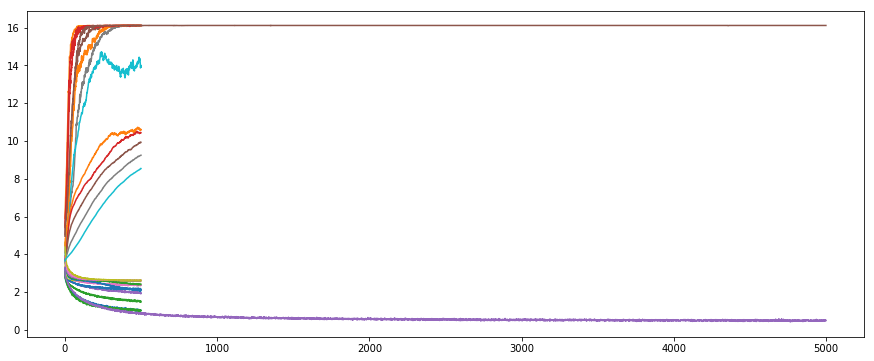

In [21]:
# plot all loss and val_loss curves against each other for comparison
Visualization.plot_losses(results)

In [22]:
results[0]['diff_dev']

array([18, 17, 17, 17, 10, 17, 17,  4,  4,  4,  1, 10, 18, 18, 17, 17, 17,
       17,  9, 20, 10, 10, 10,  8, 14, 10,  1, 17, 17,  1, 17, 17, 10, 10,
       10,  8, 10, 10,  4,  9,  1,  3,  8, 17,  9, 17,  4,  4,  4,  4,  8,
        9,  9,  8,  1, 18,  4,  8,  4,  4,  4, 10, 20, 20, 20,  8, 14, 14,
       14,  9,  4,  8, 20, 20, 18, 20, 20,  1,  8,  4,  8,  4,  4, 20, 17,
       20, 20, 18,  1,  1,  4,  8,  9,  4, 20, 20, 14,  4, 17, 20, 18,  8,
        4,  4, 14,  1, 18,  8,  1,  9, 14,  8, 20, 20, 14, 14,  4, 18,  8,
        1, 14, 14,  1, 20, 20, 20,  1, 20,  1,  1,  1,  1,  1, 14,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  3,  1,  1, 14,  1,  1,  1,  1,  1,  3,
        1,  1,  1,  3, 17, 17, 17,  1,  3,  1,  3,  1,  1, 14,  9,  1, 14,
        2,  2,  2, 24, 24, 24,  1, 14,  1,  7,  7,  7,  2,  2,  2,  2, 25,
       14, 24, 19, 24, 25,  2,  2,  2,  5,  2, 16, 25, 12,  3, 25, 14, 24,
       24, 19,  2,  2, 14, 14,  6, 12, 24, 19, 16, 24, 14, 14, 24, 24, 24,
       14, 14, 19, 11, 16

In [23]:
results[0]['diff_test']

array([11, 10, 15,  6,  6,  6,  6,  6,  5, 13,  5, 13, 10, 18, 10, 10, 10,
       24,  6,  6,  6,  6,  4, 18, 18,  4,  0,  0, 10, 10, 24, 23,  6, 24,
        4, 18, 18, 13, 13,  0, 24, 10, 24, 10, 23,  6, 10, 24, 13, 18, 18,
       18, 13,  0, 13,  0, 10,  3,  6,  6,  3, 10,  6,  6,  6, 10, 18, 13,
        0,  6, 13, 13,  6,  6, 11, 10, 10,  3, 18,  4,  4,  4, 13, 13, 13,
        5, 23, 23, 23, 23, 23,  4, 13,  5,  6, 13, 13,  6,  6, 10,  5,  6,
       23, 23,  4, 13, 11, 11, 13, 13, 13, 13, 22, 13, 22, 22, 15,  4, 13,
       13, 11, 13, 13, 13, 13,  5, 10,  6, 11,  3,  4, 13,  6, 22,  3, 13,
       13,  6, 13,  6, 13, 11, 13, 15,  5, 10, 22, 11, 22, 13, 13, 13, 13,
        3, 11, 11, 11, 15, 10, 22, 11, 13,  3, 15, 13,  3, 23, 23, 18, 16,
       16, 25,  3, 16,  3,  3, 16, 16, 16, 25, 25,  8, 27, 27,  3,  3,  3,
        3, 16,  9,  3, 25, 25,  8,  8,  9,  1,  1, 25, 16, 27, 27,  9, 27,
       25, 16,  0, 16,  8, 27, 16, 16, 16,  0, 21,  9,  3, 16, 16,  1, 14,
       14, 16, 13, 16, 16

In [24]:
results[0]['diff_dev_lt']

array([  7,   8,   9,  10,  26,  29,  38,  40,  41,  46,  47,  48,  49,
        54,  56,  58,  59,  60,  70,  77,  79,  81,  82,  88,  89,  90,
        93,  97, 102, 103, 105, 108, 116, 119, 122, 126, 128, 129, 130,
       131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 160, 161,
       162, 163, 164, 165, 168, 170, 171, 172, 176, 178, 182, 183, 184,
       185, 192, 193, 194, 195, 196, 200, 206, 207, 210, 227, 235, 237,
       238, 248, 249, 250, 263, 264, 268, 269, 273, 275, 280, 281, 287,
       294, 295, 296, 297, 303, 306, 307, 308, 309, 310, 311, 313, 319,
       323, 326, 327, 328, 329, 336], dtype=int64)

In [25]:
results[0]['results_commons']

,lat,lon,text,val_std
0,31.375,81.125,"(31.375, 81.125)=1",1.500
1,21.375,66.125,"(21.375, 66.125)=4",0.375


In [26]:
results[0]['results_dev'][:10]

,lat,lon,text,val_std
0,6.375,81.125,"(6.375, 81.125)=4",0.1
1,6.375,83.625,"(6.375, 83.625)=4",0.1
2,6.375,86.125,"(6.375, 86.125)=4",0.1
3,6.375,88.625,"(6.375, 88.625)=1",1.0
4,11.375,63.625,"(11.375, 63.625)=1",1.0
5,11.375,71.125,"(11.375, 71.125)=1",1.0
6,11.375,93.625,"(11.375, 93.625)=4",0.1
7,13.875,66.125,"(13.875, 66.125)=1",1.0
8,13.875,68.625,"(13.875, 68.625)=3",0.2
9,13.875,81.125,"(13.875, 81.125)=4",0.1


In [27]:
result_nodes = []
for index, model in enumerate(results):
    result_nodes.append(Visualization.create_plot_nodes(model['results_dev'], 'rgba(255, 0, 0, 0.25)', 'dev-{}'.format(index)))
    result_nodes.append(Visualization.create_plot_nodes(model['results_test'], 'rgba(0, 255, 0, 0.25)', 'test-{}'.format(index)))
    result_nodes.append(Visualization.create_plot_nodes(model['results_commons'], 'rgba(0, 0, 255, 0.5)', 'commons-{}'.format(index)))

layout = Visualization.create_plot_layout('Validation loss < 7 days for all models')

# display the plot
fig = dict(data=result_nodes, layout=layout)
url = plotly.offline.iplot(fig)

Common points: 27-30 (27: 12.6°-67°), 121-122 (121: 30°-75°), 150-155 (150: 35°-82°) 